<a href="https://colab.research.google.com/github/yeonheuiyeon/Machine-Learning-Practice/blob/master/0609%EC%97%B0%ED%9D%AC%EC%97%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. LSun bedroom data
기본적으로 100사이즈의 무작위 노이즈(아래에서 변경할 수 있음)와 침실을 대상으로 하는 이미지를 입력으로 구성한다. 그래서 우리는 tfm_y=트루트 변환을 한 다음 xs가 아닌 ys에 정상화를 적용하는 것이다.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.vision.gan import *

In [0]:
path = untar_data(URLs.LSUN_BEDROOMS)

우리가 사용하는 데이터세트가 바로 이 LSUN 침실 데이터세트가기 때문에 흥미롭다. 이 데이터세트는 우리의 URL에 제공된 것이다. 침실에는 침실이 많고 많은 것들이 있다. 우리가 이 경우에 사용하는 접근법은 "침실을 만들 수 있을까?"라고 말하는 것이다. 그래서 우리가 실제로 하는 일은 발전기에 대한 입력이 우리가 청소하는 이미지가 아니라는 겁니다. 우리는 실제로 발전기의 무작위 소음에 반응한다. 그렇다면 발전기의 임무는 "비평가들이 그 출력물과 진짜 침실의 차이를 구별할 수 없는 어떤 것으로 무작위 소음을 바꿀 수 있는가?"이다. 우리는 어떤 사전 훈련이나 이런 것을 빠르고 쉽게 만드는 어떤 것도 하지 않는다. 그래서 이것은 매우 전통적인 접근법이다. 하지만 보시다시피, 여러분은 여전히 GANLearner에 가고 실제로 오래된 방식의 접근법인 wgan 버전이 있다. 하지만 그냥 자료와 발전기, 그리고 평론가를 일반적인 방법으로 제출하고 적합하다고 부르는 겁니다.

여러분은 (이 경우, 우리는 쇼_이미지를 가지고 있다) 신기원을 이룬 후에, 그것은 훌륭한 침실이나 두세 개의 침실을 만드는 것이 아니다. 그리고 이런 종류의 GAN의 초기에는 어떤 것도 잘 하지 못한다는 것을 정말로 알 수 있다. 하지만 결국, 몇 시간 동안 훈련을 받은 후에, 그것은 침실 같은 것들을 만들어 내고 있다. 


GAN은 Generative Teacheral Nets를 의미하며 Ian Goodfellow에 의해 발명되었다. 발전기와 평론가의 두 모델을 동시에 양성한다는 개념이다. 제너레이터는 데이터 세트에 있는 것과 비슷한 새로운 이미지를 만들려고 할 것이고, 비평가들은 제너레이터가 하는 것들로부터 실제 이미지를 분류하려고 할 것이다. 제너레이터는 이미지를 반환하고, 비평가자는 단일 숫자(일반적으로 가짜 이미지의 경우 0, 실제 이미지의 경우 1.)를 반환한다.

우리는 각 단계(약간)에서 다음과 같이 서로 대항하여 그들을 훈련시킨다.

1. 제너레이터를 동결하고 비평가를 한 단계씩 교육하기
실제 이미지 한 묶음 가져오기(실제 이미지라고 함)
한 묶음의 가짜 이미지 생성(그것을 가짜라고 부르자)
비평가에게 각 배치들을 평가하게 하고 그것으로부터 손실 함수를 계산하게 한다. 중요한 부분은 그것이 실제 이미지의 탐지를 긍정적으로 보상하고 가짜 이미지들을 처벌한다는 것이다.
2. critic 의 가중치를 이 손실의 구배와 바꾸다.
critic를 동결시키고  generator 를 한 단계씩 훈련시킨다.
가짜 이미지 한 묶음 생성
그것에 대해 평론가를 평가하다.
그것이 실제 이미지라고 생각하는 비평가에게 보상을 주는 손실을 반환한다
중요한 부분은 그것이 실제 이미지들의 탐지를 긍정적으로 보상하고 가짜 이미지들을 처벌하는 것이다.

우리는 gan_learner에게 전달할 generator와 critic를 만든다. noise_size는 우리의 발생기가 이미지를 만드는 임의 벡터의 크기.


In [0]:
def get_data(bs, size):
    return (GANItemList.from_folder(path, noise_sz=100)
               .split_none()
               .label_from_func(noop)
               .transform(tfms=[[crop_pad(size=size, row_pct=(0,1), col_pct=(0,1))], []], size=size, tfm_y=True)
               .databunch(bs=bs)
               .normalize(stats = [torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])], do_x=False, do_y=True))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

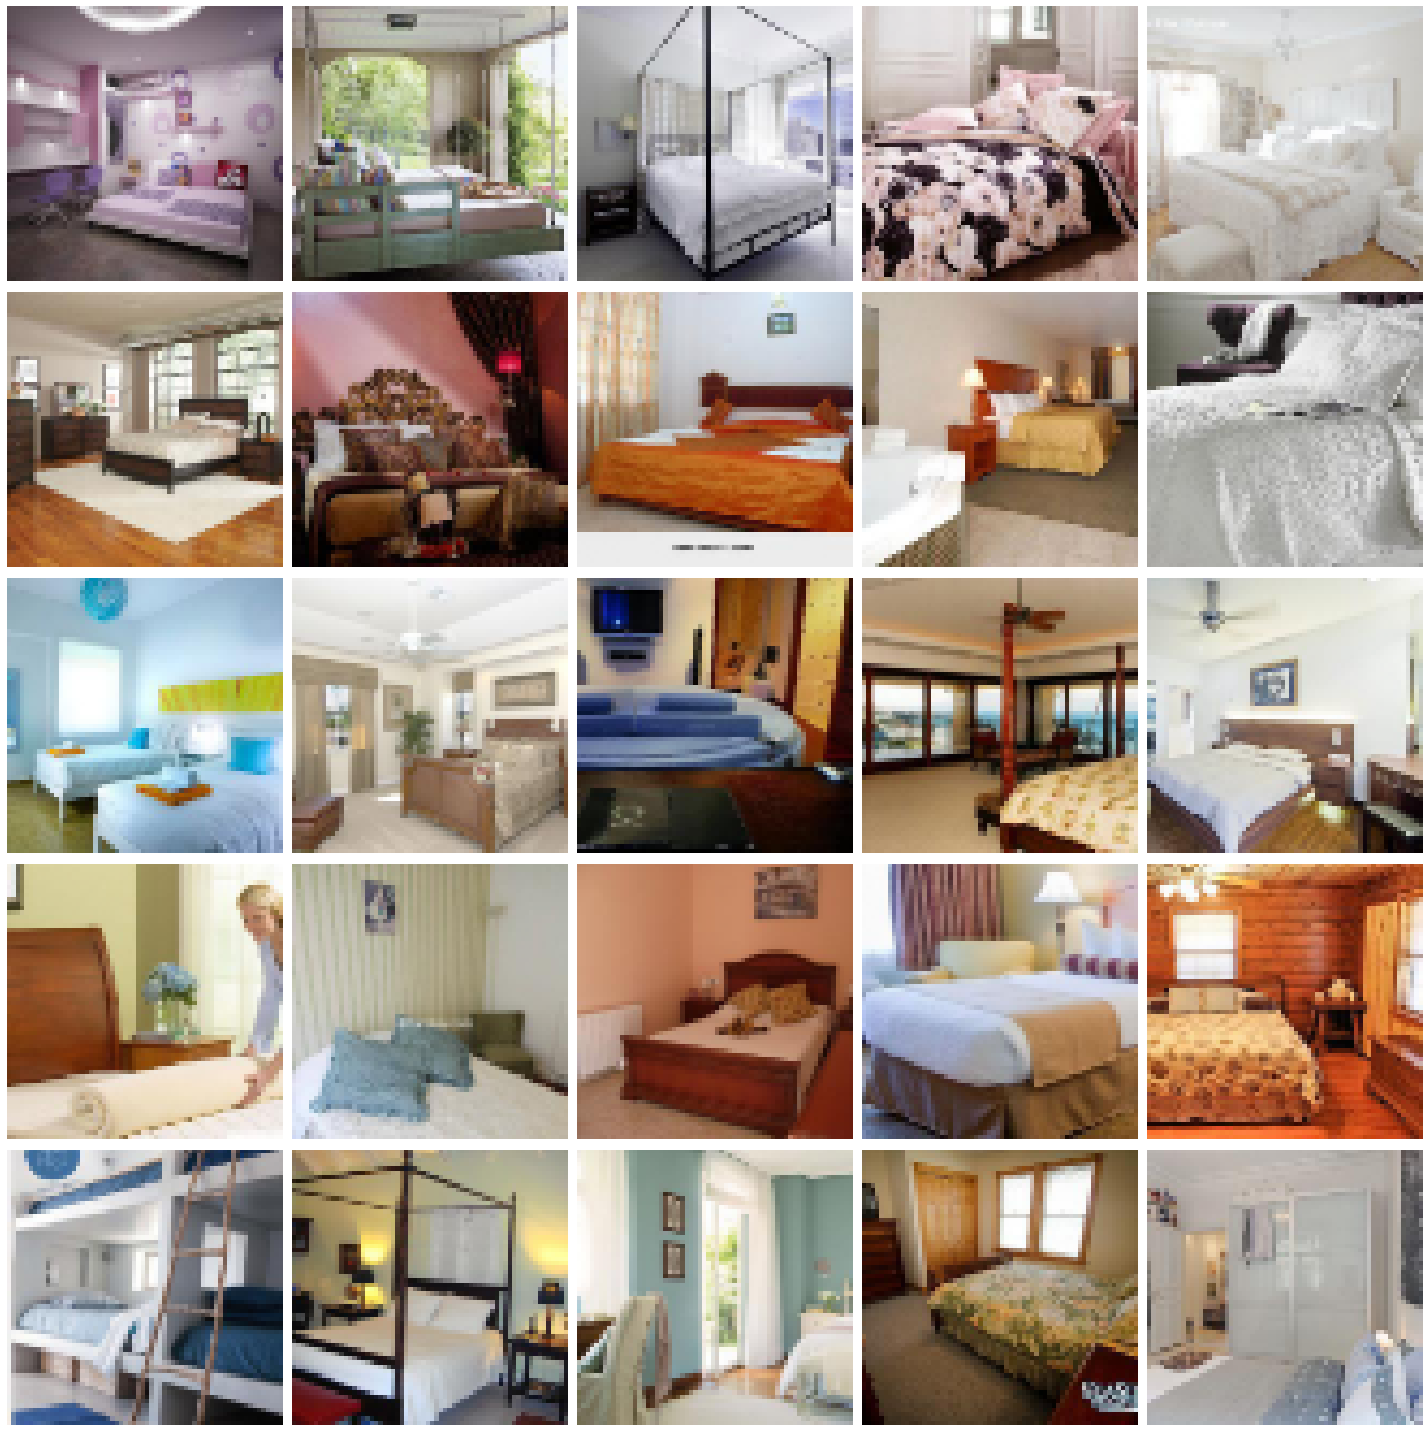

In [0]:
data = get_data(128, 64)
data.show_batch(rows=5)

In [0]:
generator = basic_generator(in_size=64, n_channels=3, n_extra_layers=1)
critic    = basic_critic   (in_size=64, n_channels=3, n_extra_layers=1)

In [0]:
learn = GANLearner.wgan(data, generator, critic, switch_eval=False,
                        opt_func = partial(optim.Adam, betas = (0.,0.99)), wd=0.)

In [0]:
learn.fit(30,2e-4)

epoch,train_loss,valid_loss,gen_loss,disc_loss,time


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please se

In [0]:
learn.gan_trainer.switch(gen_mode=True)
learn.show_results(ds_type=DatasetType.Train, rows=16, figsize=(8,8))

In [0]:
from fastai.text import *

In [0]:
bs=64

In [0]:
path = untar_data(URLs.HUMAN_NUMBERS)
path.ls()

In [0]:
def readnums(d): return [', '.join(o.strip() for o in open(path/d).readlines())]

In [0]:
train_txt = readnums('train.txt'); train_txt[0][:80]

In [0]:
valid_txt = readnums('valid.txt'); valid_txt[0][-80:]

In [0]:
train = TextList(train_txt, path=path)
valid = TextList(valid_txt, path=path)

src = ItemLists(path=path, train=train, valid=valid).label_for_lm()
data = src.databunch(bs=bs)

In [0]:
train[0].text[:80]

In [0]:
len(data.valid_ds[0][0].data)

In [0]:
data.bptt, len(data.valid_dl)

In [0]:
13017/70/bs

In [0]:
it = iter(data.valid_dl)
x1,y1 = next(it)
x2,y2 = next(it)
x3,y3 = next(it)
it.close()

In [0]:
x1.numel()+x2.numel()+x3.numel()

In [0]:
x1.shape,y1.shape

In [0]:
x2.shape,y2.shape

#2, Human numbers

In [0]:
from fastai.text import *

In [0]:
bs=64

In [3]:
path = untar_data(URLs.HUMAN_NUMBERS)
path.ls()

[PosixPath('/root/.fastai/data/human_numbers/valid.txt'),
 PosixPath('/root/.fastai/data/human_numbers/train.txt')]

In [0]:
def readnums(d): return [', '.join(o.strip() for o in open(path/d).readlines())]

In [5]:
train_txt = readnums('train.txt'); train_txt[0][:80]
valid_txt = readnums('valid.txt'); valid_txt[0][-80:]
train = TextList(train_txt, path=path)
valid = TextList(valid_txt, path=path)

src = ItemLists(path=path, train=train, valid=valid).label_for_lm()
data = src.databunch(bs=bs)

In [6]:
train[0].text[:80]

'xxbos one , two , three , four , five , six , seven , eight , nine , ten , eleve'

문서가 하나뿐이므로, train[0]은 텍스트 캡처 문서로 텍스트 목록의 내용을 캡처하는 방법이며, 여기에 처음 80자가 표시된다. 특별한 토큰 xxbos로 시작한다. xx로 시작하는 모든 것은 특별한 fast.ai 토큰이고 bos는 스트림 토큰의 시작이다. 기본적으로 이것이 문서의 시작이라고 되어 있는데, NLP에서는 언제 문서가 시작되는지 알고 여러분의 모델이 그것들을 인식하는 법을 배울 수 있도록 하는 것이 매우 도움이 된다.

In [7]:
len(data.valid_ds[0][0].data)
data.bptt, len(data.valid_dl)
13017/70/bs

2.905580357142857

우리가 요청한 배치 크기는 64이고, 그리고 기본적으로 70.bpt라고 불리는 것을 사용한다. bptt는 우리가 간단히 언급했듯이, "시간을 통한 후방 지원"을 의미한다. 그게 바로 시퀀스 길이야. 64개의 문서 세그먼트를 각각 한 번에 살펴보는 70개의 단어 목록으로 나누었다. 그래서 검증 세트를 위해 13,000개의 토큰으로 구성된 전체 문자열을 가져다가 64개의 동일한 크기의 섹션으로 분할하는 겁니다. 사람들은 종종 내가 뭔가 다른 말을 하고 있다고 생각한다. 나는 그들이 길이가 64세라고 말하지 않았다 - 그들은 아니다. 그것들은 대략 같은 크기의 64개 입니다. 그래서 우리는 문서 1의 1/64를 가져간다. 두 번째 1/64 - 부품 2

그리고 그 문서들의 1/64에 대해, 우리는 그것들을 길이 70의 조각으로 나누었다. 그럼 이제 그 1만 3천개의 토큰에 대해 몇 개의 묶음이 있다고 합시다. 음, 배치 사이즈로 나누고 70으로 나누면 3개 배치로 나누어질 겁니다.

In [0]:
it = iter(data.valid_dl)
x1,y1 = next(it)
x2,y2 = next(it)
x3,y3 = next(it)
it.close()

이 데이터 집합의 어휘를 잡으면 되고, 어휘는 텍스트가 있기 때문에, 우리가 정확히 같은 것을 보지만 텍스트로 본다면, 그것은 단지 어휘에서 찾을 수 있을 것이다. 여기 xxbos가 8천1개 보이시죠, y에 xxbo가 없고, 8천개만 보이시죠. 그래서 xxbos가 8이 되고, 8이 지나면 1,000이 되고, 천이 지나면 1이 된다.

In [9]:
x1.numel()+x2.numel()+x3.numel()

13440

In [10]:
x1.shape,y1.shape

(torch.Size([64, 70]), torch.Size([64, 70]))

In [11]:
x2.shape,y2.shape

(torch.Size([64, 70]), torch.Size([64, 70]))

In [12]:
x1[:,0]

tensor([ 2,  9, 11, 12, 13, 11, 10,  9, 10, 14, 19, 25, 19, 15, 16, 11, 19,  9,
        10,  9, 19, 25, 19, 11, 19, 11, 10,  9, 19, 20, 11, 26, 20, 23, 20, 20,
        24, 20, 11, 14, 11, 11,  9, 14,  9, 20, 10, 20, 35, 17, 11, 10,  9, 17,
         9, 20, 10, 20, 11, 20, 11, 20, 20, 20], device='cuda:0')

In [13]:
y1[:,0]

tensor([19, 19, 27, 10,  9, 12, 32, 19, 26, 10, 11, 15, 11, 10,  9, 15, 11, 19,
        26, 19, 11, 18, 11, 18,  9, 18, 21, 19, 10, 10, 20,  9, 11, 16, 11, 11,
        13, 11, 13,  9, 13, 14, 20, 10, 20, 11, 24, 11,  9,  9, 16, 17, 20, 10,
        20, 11, 24, 11, 19,  9, 19, 11, 11, 10], device='cuda:0')

In [0]:
v = data.valid_ds.vocab

In [15]:
v.textify(x1[0])

'xxbos eight thousand one , eight thousand two , eight thousand three , eight thousand four , eight thousand five , eight thousand six , eight thousand seven , eight thousand eight , eight thousand nine , eight thousand ten , eight thousand eleven , eight thousand twelve , eight thousand thirteen , eight thousand fourteen , eight thousand fifteen , eight thousand sixteen , eight thousand seventeen , eight'

In [16]:
v.textify(y1[0])

'eight thousand one , eight thousand two , eight thousand three , eight thousand four , eight thousand five , eight thousand six , eight thousand seven , eight thousand eight , eight thousand nine , eight thousand ten , eight thousand eleven , eight thousand twelve , eight thousand thirteen , eight thousand fourteen , eight thousand fifteen , eight thousand sixteen , eight thousand seventeen , eight thousand'

In [17]:
v.textify(x2[1])

'eight thousand sixty , eight thousand sixty one , eight thousand sixty two , eight thousand sixty three , eight thousand sixty four , eight thousand sixty five , eight thousand sixty six , eight thousand sixty seven , eight thousand sixty eight , eight thousand sixty nine , eight thousand seventy , eight thousand seventy one , eight thousand seventy two , eight thousand seventy three , eight thousand'

그러면 처음부터 다시 시작할 수 있지만 배치 지수 1이 배치 번호 2인 배치 지수 1을 보십시오. 이제 우리는 계속할 수 있다. 8,040에서 8,046으로 살짝 건너뛰는 것은 마지막 미니 배치가 완성되지 않았기 때문이다. 이것은 모든 미니 배치가 이전의 미니 배치와 결합한다는 것을 의미한다. 그래서 당신은 x1[0]에서 x2[0]로 직진할 수 있다. - 8,023, 8,024가 계속된다. 만약 여러분이 같은 것을 :,1에 가져갔다면, 여러분은 또한 그들이 가입하는 것을 볼 수 있을 것이다. 그래서 모든 작은 배치는 결합한다.

In [18]:
data.show_batch(ds_type=DatasetType.Valid)

idx,text
0,"thousand forty seven , eight thousand forty eight , eight thousand forty nine , eight thousand fifty , eight thousand fifty one , eight thousand fifty two , eight thousand fifty three , eight thousand fifty four , eight thousand fifty five , eight thousand fifty six , eight thousand fifty seven , eight thousand fifty eight , eight thousand fifty nine , eight thousand sixty , eight thousand sixty"
1,"eight , eight thousand eighty nine , eight thousand ninety , eight thousand ninety one , eight thousand ninety two , eight thousand ninety three , eight thousand ninety four , eight thousand ninety five , eight thousand ninety six , eight thousand ninety seven , eight thousand ninety eight , eight thousand ninety nine , eight thousand one hundred , eight thousand one hundred one , eight thousand one"
2,"thousand one hundred twenty four , eight thousand one hundred twenty five , eight thousand one hundred twenty six , eight thousand one hundred twenty seven , eight thousand one hundred twenty eight , eight thousand one hundred twenty nine , eight thousand one hundred thirty , eight thousand one hundred thirty one , eight thousand one hundred thirty two , eight thousand one hundred thirty three , eight thousand"
3,"three , eight thousand one hundred fifty four , eight thousand one hundred fifty five , eight thousand one hundred fifty six , eight thousand one hundred fifty seven , eight thousand one hundred fifty eight , eight thousand one hundred fifty nine , eight thousand one hundred sixty , eight thousand one hundred sixty one , eight thousand one hundred sixty two , eight thousand one hundred sixty three"
4,"thousand one hundred eighty three , eight thousand one hundred eighty four , eight thousand one hundred eighty five , eight thousand one hundred eighty six , eight thousand one hundred eighty seven , eight thousand one hundred eighty eight , eight thousand one hundred eighty nine , eight thousand one hundred ninety , eight thousand one hundred ninety one , eight thousand one hundred ninety two , eight thousand"


## * Single fully connected model



In [0]:
data = src.databunch(bs=bs, bptt=3)

In [20]:
x,y = data.one_batch()
x.shape,y.shape

(torch.Size([64, 3]), torch.Size([64, 3]))

In [21]:
nv = len(v.itos); nv

40

In [0]:
nh=64

In [0]:
def loss4(input,target): return F.cross_entropy(input, target[:,-1])
def acc4 (input,target): return accuracy(input, target[:,-1])

In [0]:
class Model0(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv,nh)  # green arrow
        self.h_h = nn.Linear(nh,nh)     # brown arrow
        self.h_o = nn.Linear(nh,nv)     # blue arrow
        self.bn = nn.BatchNorm1d(nh)
        
    def forward(self, x):
        h = self.bn(F.relu(self.h_h(self.i_h(x[:,0]))))
        if x.shape[1]>1:
            h = h + self.i_h(x[:,1])
            h = self.bn(F.relu(self.h_h(h)))
        if x.shape[1]>2:
            h = h + self.i_h(x[:,2])
            h = self.bn(F.relu(self.h_h(h)))
        return self.h_o(h)

In [0]:
learn = Learner(data, Model0(), loss_func=loss4, metrics=acc4)

In [26]:
learn.fit_one_cycle(6, 1e-4)

epoch,train_loss,valid_loss,acc4,time
0,3.457413,3.529503,0.122243,00:01
1,2.545175,2.577697,0.434743,00:01
2,2.029516,2.187279,0.463465,00:01
3,1.831310,2.067876,0.467831,00:01
4,1.761132,2.036798,0.468290,00:01
5,1.746274,2.032990,0.468290,00:01


## * Same thing with a loop

In [0]:
class Model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv,nh)  # green arrow
        self.h_h = nn.Linear(nh,nh)     # brown arrow
        self.h_o = nn.Linear(nh,nv)     # blue arrow
        self.bn = nn.BatchNorm1d(nh)
        
    def forward(self, x):
        h = torch.zeros(x.shape[0], nh).to(device=x.device)
        for i in range(x.shape[1]):
            h = h + self.i_h(x[:,i])
            h = self.bn(F.relu(self.h_h(h)))
        return self.h_o(h)

In [0]:
learn = Learner(data, Model1(), loss_func=loss4, metrics=acc4)

In [29]:
learn.fit_one_cycle(6, 1e-4)

epoch,train_loss,valid_loss,acc4,time
0,3.616102,3.676865,0.042969,00:01
1,2.599667,2.719017,0.443934,00:01
2,2.046735,2.308487,0.460478,00:01
3,1.848678,2.182092,0.466452,00:01
4,1.779153,2.149350,0.467142,00:01
5,1.764490,2.145869,0.467142,00:01


## * Multi fully connected model




In [0]:
data = src.databunch(bs=bs, bptt=20)

In [31]:
x,y = data.one_batch()
x.shape,y.shape

(torch.Size([64, 20]), torch.Size([64, 20]))

In [0]:
class Model2(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv,nh)
        self.h_h = nn.Linear(nh,nh)
        self.h_o = nn.Linear(nh,nv)
        self.bn = nn.BatchNorm1d(nh)
        
    def forward(self, x):
        h = torch.zeros(x.shape[0], nh).to(device=x.device)
        res = []
        for i in range(x.shape[1]):
            h = h + self.i_h(x[:,i])
            h = F.relu(self.h_h(h))
            res.append(self.h_o(self.bn(h)))
        return torch.stack(res, dim=1)

In [0]:
learn = Learner(data, Model2(), metrics=accuracy)

In [34]:
learn.fit_one_cycle(10, 1e-4, pct_start=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,3.863004,3.610610,0.065554,00:00
1,3.679890,3.408270,0.175639,00:00
2,3.460188,3.228297,0.236009,00:00
3,3.237566,3.079875,0.306960,00:00
4,3.037129,2.964060,0.336506,00:00
5,2.875462,2.879684,0.351776,00:00
6,2.755144,2.824785,0.361506,00:00
7,2.673437,2.795193,0.366264,00:00
8,2.624064,2.783821,0.367969,00:00
9,2.598473,2.782114,0.368182,00:00


## * Maintain state

In [0]:
class Model3(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv,nh)
        self.h_h = nn.Linear(nh,nh)
        self.h_o = nn.Linear(nh,nv)
        self.bn = nn.BatchNorm1d(nh)
        self.h = torch.zeros(bs, nh).cuda()
        
    def forward(self, x):
        res = []
        h = self.h
        for i in range(x.shape[1]):
            h = h + self.i_h(x[:,i])
            h = F.relu(self.h_h(h))
            res.append(self.bn(h))
        self.h = h.detach()
        res = torch.stack(res, dim=1)
        res = self.h_o(res)
        return res

In [0]:
learn = Learner(data, Model3(), metrics=accuracy)

In [37]:
learn.fit_one_cycle(20, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.651403,3.493270,0.160227,00:00
1,3.046770,2.638732,0.453196,00:00
2,2.304478,2.113830,0.317045,00:00
3,1.859160,2.055757,0.315980,00:00
4,1.644717,2.041410,0.316619,00:00
5,1.541022,2.069956,0.316974,00:00
6,1.462642,1.901579,0.382955,00:00
7,1.373548,1.971447,0.419815,00:00
8,1.279137,1.816706,0.482386,00:00
9,1.179972,1.663833,0.527415,00:00


## * nn.RNN

In [0]:
class Model4(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv,nh)
        self.rnn = nn.RNN(nh,nh, batch_first=True)
        self.h_o = nn.Linear(nh,nv)
        self.bn = BatchNorm1dFlat(nh)
        self.h = torch.zeros(1, bs, nh).cuda()
        
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = h.detach()
        return self.h_o(self.bn(res))

In [0]:
learn = Learner(data, Model4(), metrics=accuracy)

In [40]:
learn.fit_one_cycle(20, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.544180,3.266812,0.239134,00:00
1,2.839660,2.286694,0.466690,00:00
2,2.152769,2.085352,0.315270,00:00
3,1.780372,2.127023,0.316051,00:00
4,1.591273,1.958950,0.378693,00:00
5,1.430579,1.896348,0.422159,00:00
6,1.246948,1.718190,0.483026,00:00
7,1.067339,1.657673,0.525994,00:00
8,0.884395,1.437250,0.560298,00:00
9,0.723842,1.463202,0.564134,00:00


## * 2-layer GRU

In [0]:
class Model5(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv,nh)
        self.rnn = nn.GRU(nh, nh, 2, batch_first=True)
        self.h_o = nn.Linear(nh,nv)
        self.bn = BatchNorm1dFlat(nh)
        self.h = torch.zeros(2, bs, nh).cuda()
        
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = h.detach()
        return self.h_o(self.bn(res))

In [0]:
learn = Learner(data, Model5(), metrics=accuracy)

In [43]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.720862,2.237259,0.483949,00:00
1,1.548787,1.298517,0.648153,00:00
2,0.742146,1.236300,0.766974,00:00
3,0.361226,0.996665,0.807102,00:00
4,0.184074,1.063904,0.813281,00:00
5,0.099246,1.130249,0.811435,00:00
6,0.056798,1.135022,0.811790,00:00
7,0.034599,1.183466,0.805043,00:00
8,0.022876,1.210381,0.806676,00:00
9,0.016636,1.221564,0.801633,00:00
